<a href="https://colab.research.google.com/github/murakami-tatsumi/colab/blob/master/mnist_keras_cnn_oneshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTをtensorflow+kerasで学習し、画面からの手書き入力を認識させるアプリを作る

最初に下の 


```
!ls
```
を実行して、
```
keras_mnist_cnn_oneshot.py  ngrok-stable-linux-amd64.zip  templates
model			    __pycache__
ngrok			    sample_data
```
が出てきたら実行環境は残っている。
```
sample_data
```
だけだったら、

1.  ngrokの初期設定
2.  index.htmlの書き出し
3.  呼び出しモジュール keras_mnist_cnn_oneshot.pyの書き出し
4.  学習及び結果モデルの保存

を事前に実行して実行環境を構築する。



In [1]:
!ls -l

total 38796
-rw-r--r-- 1 root root     1139 Aug 16 07:09 keras_mnist_cnn_oneshot.py
drwxr-xr-x 2 root root     4096 Aug 16 04:21 model
-rwxr-xr-x 1 root root 26092507 Jul 20 01:16 ngrok
-rw-r--r-- 1 root root 13607069 Aug 16 04:19 ngrok-stable-linux-amd64.zip
drwxr-xr-x 2 root root     4096 Aug 16 05:57 __pycache__
drwxr-xr-x 1 root root     4096 Aug  2 16:06 sample_data
drwxr-xr-x 2 root root     4096 Aug 16 04:19 templates


### 初期設定とモデルの構築

In [2]:
#
# 1. ngrokの初期設定
#
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 1PMRCbWcgdmypamYcEK36NVWjmS_iL7E7vRd31B7EYLjJEBn

--2019-08-16 04:19:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.60.111, 52.200.123.104, 52.45.248.244, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.60.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  15.7MB/s    in 0.8s    

2019-08-16 04:19:08 (15.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [3]:

#
# 2. index.htmlの書き出し
#

#Writing to html file on colab
import os

html = """
<!DOCTYPE html>
<html>
<head>
  <meta charset="UTF-8">
  <title>文字認識</title>
</head>
<body onload="init()" style="text-align:center;">
<h1>数字手書き文字認識</h1>
<div>
  <!-- ユーザーからの入力を受け付けるCanvas -->
  <canvas id="main_cv" width="300" height="300"
       style="border: solid 1px gray"></canvas>
  <!-- 送信用にリサイズした結果を描画するCanvas -->
  <canvas id="back_cv" width="28" height="28"
       style="border:red solid 1px"></canvas>
</div>
<div>
  予測:<span id="result" style="font-size:5em;"></span>
</div>
<div>
  <button onclick="resetCanvas()"
    style="font-size:1.5em;">
    キャンバスのリセット</button>
</div>

<script type="text/javascript">
// API
var API_PREDICT = location.href + "api?";

// 変数など
var main_cv, ctx, main_r, back_cv, back_ctx;
var isDown, s_pt, border = 20;

// 初期化 --- (*1)
function init() {
  // キャンバスのオブジェクトやコンテキストを取得
  main_cv = $("#main_cv");
  ctx = main_cv.getContext("2d");
  // キャンバスの位置とサイズを取得
  main_r = main_cv.getBoundingClientRect();
  // リサイズ処理用のイメージ
  back_cv = $("#back_cv");
  back_ctx = back_cv.getContext("2d");

  // マウスイベントの設定 --- (*2)
  main_cv.onmousedown = function (e) {
    isDown = true;
    s_pt = getXY(e);
    ctx.beginPath();
    ctx.lineWidth = border;
    ctx.lineCap = "round";
    ctx.strokeStyle = "white";
    ctx.moveTo(s_pt.x, s_pt.y);
  };
  main_cv.onmousemove = function (e) {
    if (!isDown) return;
    var pt = getXY(e);
    ctx.lineTo(pt.x, pt.y);
    ctx.stroke();
    s_pt = pt;
    ctx.beginPath();
    ctx.moveTo(pt.x, pt.y);
  };
  main_cv.onmouseup = function (e) {
    if (!isDown) return;
    isDown = false;
    ctx.closePath();
    recognize();
  };
  main_cv.onmouseout = main_cv.onmouseup;

  // 画面を白くする
  resetCanvas();
}

// マウスの座標を取得 --- (*4)
function getXY(e) {
  var x = e.clientX;
  var y = e.clientY;
  x -= main_r.left;
  y -= main_r.top;
  return {"x":x, "y":y};
}

// キャンバスの初期化
function resetCanvas() {
  ctx.clearRect(0, 0, main_cv.width, main_cv.height);
  ctx.fillStyle = 'black';
  ctx.fillRect(0, 0, main_cv.width, main_cv.height);
  ctx.beginPath();
  back_ctx.clearRect(0,0,back_cv.width,back_cv.height);
  back_ctx.beginPath();
  $("#result").innerHTML = "";
  x_min = main_cv.width;
  x_max = 0;
  y_min = main_cv.height;
  y_max = 0;
}

// コピー --- (*5)
function copyToBack() {
  back_ctx.fillStyle = "black";
  back_ctx.fillRect(0,0,28,28);
  back_ctx.drawImage(main_cv,
    0, 0, main_cv.width, main_cv.height,
    0, 0, 28, 28);
}

// パターンを作成する --- (*6)
function getPixelData() {
  //　画像を28x28にリサイズ
  copyToBack();
  // 画像イメージを取得 --- (*7)
  var img = back_ctx.getImageData(0, 0, 28, 28).data;
  var buf = [];
  console.log(img);
  for (var i = 0; i < 28 * 28; i++) {
    var k = i * 4;
    var r = img[k + 0]; // red
    var g = img[k + 1]; // green
    var b = img[k + 2]; // blue
    var a = img[k + 3]; // alpha
    var v = Math.floor((r + g + b) / 3.0); // ---- (*7a)
    buf.push(v);
  }
  return buf.join(",");
}

// 文字認識処理を実行 --- (*8)
function recognize() {
  // 手書き文字のピクセルを取得
  var txt = getPixelData();
  // サーバーへ送信 --- (*9)
  var uri = API_PREDICT + "p=" + txt;
  $ajax(uri, function (xhr, txt) {
    $("#result").innerHTML = "" + txt;
    console.log("predict=" + txt);
  });
}

// DOMを返す
function $(q) { return document.querySelector(q); }

// Ajax関数
function $ajax(url, callback) {
  var xhr = new XMLHttpRequest();
  xhr.open('GET', url, true);
  xhr.onreadystatechange = function() {
    if (xhr.readyState == 4) { //通信完了
      if (xhr.status == 200) { //HTTPステータス200
        callback(xhr, xhr.responseText);
      }
    }
  };
  xhr.send(''); // 通信を開始
  return xhr;
}
</script>
</body>
</html>

"""

#Saving html file
if not os.path.isdir( "templates" ):
    os.makedirs( "templates" )
with open("templates/index.html", mode='w') as f:
    f.write(html)
print ('完了！')


完了！


In [2]:
#
# 3. 呼び出しモジュール keras_mnist_cnn_oneshot.pyの書き出し
#

#Writing to python file on colab
import os

python = """
# coding: utf-8
import sys
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import matplotlib.pyplot as plt

# 保存したmodelのロード
model = load_model('model/mnist-cnn.h5')
model.summary()
print ('oneshot ready')
sys.stdout.flush()

# kerasのバグ対応（モデルを別スレッドで使用できない）
graph = tf.get_default_graph()

def oneshot(line):
  # kerasのバグ対応（モデルを別スレッドで使用できない）
  with graph.as_default():
    w = list(map(lambda x: float(int(x)), line.split(',')))
    x = np.reshape(w, (1, 28, 28, 1))
    x = x.astype('float32')
    x /= 255
    out = model.predict(x)
    ans = np.argmax(out.data)

    plt.imshow(np.reshape(w, (28, 28)), cmap =plt.cm.gray_r)
    plt.show()
    print('予測：',ans)
    print('確率：',out[0][ans])    
    sys.stdout.flush()
    
    return ans

if __name__ == "__main__":
  while True:
    str = input()
    if (str == 'end'):
      break
    r = oneshot(str)
    print (r)
    sys.stdout.flush()

  # 終了
  print ('oneshot end')
  sys.stdout.flush()
  exit()

"""

#Saving python file
with open("keras_mnist_cnn_oneshot.py", mode='w') as f:
    f.write(python)
print ('完了！')    


完了！


In [20]:
#
# 4. 学習及び結果モデルの保存
#

# coding: utf-8
import os
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 検証用に保存
x_test_x = x_test

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print ('K.image_data_format() = ', K.image_data_format())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Saving model file
if not os.path.isdir( "model" ):
    os.makedirs( "model" )
model.save('model/mnist-cnn.h5')
model.summary()
print ('完了！')    

K.image_data_format() =  channels_last
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 9s 155us/step - loss: 0.2695 - acc: 0.9172 - val_loss: 0.0676 - val_acc: 0.9780
Epoch 2/12
60000/60000 [==============================] - 9s 147us/step - loss: 0.0896 - acc: 0.9739 - val_loss: 0.0511 - val_acc: 0.9834
Epoch 3/12
60000/60000 [==============================] - 9s 147us/step - loss: 0.0660 - acc: 0.9805 - val_loss: 0.0352 - val_acc: 0.9878
Epoch 4/12
60000/60000 [==============================] - 9s 147us/step - loss: 0.0540 - acc: 0.9839 - val_loss: 0.0308 - val_acc: 0.9890
Epoch 5/12
60000/60000 [==============================] - 9s 146us/step - loss: 0.0479 - acc: 0.9854 - val_loss: 0.0266 - val_acc: 0.9911
Epoch 6/12
60000/60000 [==============================] - 9s 147us/step - loss: 0.0396 - acc: 0.9880 - val_loss: 0.0294 - val_acc: 0.9894
Epoch 7/12

### 手書き入力判定処理（oneshot）の起動

下のセルを起動すると

5. ngrokで仮想ドメイン取得
6. mnist oneshot処理の起動とwebサーバー立ち上げ

処理が開始され、手書き入力の待ち状態になる。<br>
5.の仮想ドメイン取得で表示されるURLをコピーして、ブラウザの別タブでURLを開くと手書き入力画面が表示される。<br>
黒い入力エリアにドラッグで数字を描いてボタンを離すと認識処理が起動され結果が画面に表示される。

https://575d2a5a.ngrok.io
loading mnist_cnn_oneshot...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)  

I0816 08:18:32.931678 140323767650176 _internal.py:122]  * Running on http://127.0.0.1:6006/ (Press CTRL+C to quit)
I0816 08:18:58.337635 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:18:58] "GET / HTTP/1.1" 200 -
I0816 08:18:59.876526 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:18:59] "GET /favicon.ico HTTP/1.1" 404 -


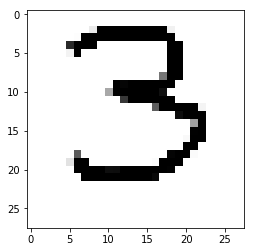

予測： 3
確率： 0.99999726


I0816 08:19:06.080064 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:19:06] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,255,255,255,255,255,255,255,255,255,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213,255,255,255,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,12,255,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,250,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,255,255,255,255,255,255,238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,198,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,161,255,255,255,255,255,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

res =  3


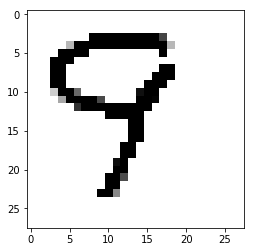

予測： 7
確率： 0.9678555


I0816 08:19:25.746276 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:19:25] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,255,255,255,255,255,255,255,255,255,255,255,255,71,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,0,0,0,0,0,0,0,0,0,255,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,50,255,255,149,0,0,0,0,0,0,0,238,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,255,255,255,255,182,0,0,0,0,255,255,251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,206,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,255

res =  7


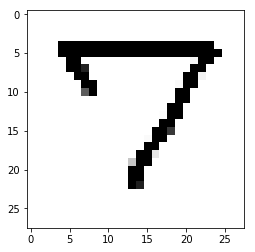

予測： 7
確率： 0.99965143


I0816 08:19:47.543127 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:19:47] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,255,255,0,0,0,0,0,0,0,0,0,255,255,220,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,255,255,12,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,6,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,163,255,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

res =  7


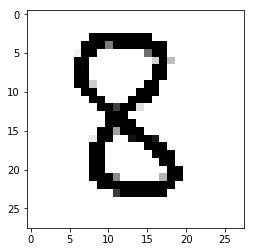

予測： 8
確率： 1.0


I0816 08:19:56.750957 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:19:56] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,132,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,255,255,0,0,0,0,0,0,146,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,46,255,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,251,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,51,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,3,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,191,255,255,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,

res =  8


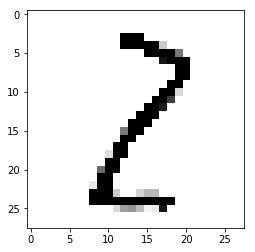

予測： 2
確率： 0.9998066


I0816 08:20:46.377729 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:20:46] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,234,255,255,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0

res =  2


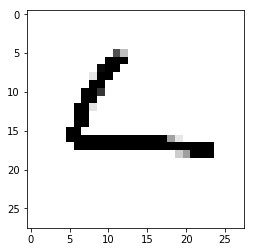

予測： 4
確率： 0.8978465


I0816 08:20:59.604393 140321214834432 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 08:20:59] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,244,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,251,255,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

res =  4


In [5]:

#
# 5. ngrokで仮想ドメイン取得
#
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
#! curl -s http://localhost:4040/api/tunnels

#
# 6. mnist oneshot処理の起動とwebサーバー立ち上げ
#

# coding: utf-8

from flask import Flask,request, render_template
import importlib

# 子処理の立ち上げ
print ('loading mnist_cnn_oneshot...')
import keras_mnist_cnn_oneshot as oneshot
importlib.reload(oneshot)

# webサーバーの立ち上げ
print ('redy!')
app = Flask(__name__)

# 入力ページ
@app.route('/')
def index():
    html = render_template('index.html')
    return html

# API
@app.route('/api')
def api():
    p = request.args.get('p')
    #print ('p = ', p)
    res = oneshot.oneshot(p)
    print ('res = ', res)
    return str(res)

if __name__ == '__main__':
    app.run(port=6006)

### 過去退避

In [29]:
#
# 5. ngrokで仮想ドメイン取得
#
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
#! curl -s http://localhost:4040/api/tunnels

#
# 6. mnist oneshot処理の起動とwebサーバー立ち上げ
#

# coding: utf-8

from flask import Flask,request, render_template
import numpy as np

# 子処理の立ち上げ
#print ('loading mnist_cnn_oneshot...')
#import keras_mnist_cnn_oneshot as oneshot

# kerasのバグ対応（モデルを別スレッドで使用できない）
graph = tf.get_default_graph()

def oneshot(line):
  # kerasのバグ対応（モデルを別スレッドで使用できない）
  with graph.as_default():
    ww = list(map(lambda x: float(int(x) / 255), line.split(',')))
    xx = np.reshape(ww, (1, 28, 28, 1))
    xx = xx.astype('float32')
    out = model.predict(xx)
    ans = np.argmax(out.data)
    print('スレッド=',ans)
    return ans

# webサーバーの立ち上げ
#print ('redy!')
app = Flask(__name__)

# 入力ページ
@app.route('/')
def index():
    html = render_template('index.html')
    return html

# API
@app.route('/api')
def api():
    p = request.args.get('p')
    #print ('p = ', p)
    res = oneshot(p)
    print ('res = ', res)
    return str(res)

if __name__ == '__main__':
    app.run(port=6006)

https://0eaacfd5.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


I0816 06:56:29.387845 139785080752000 _internal.py:122]  * Running on http://127.0.0.1:6006/ (Press CTRL+C to quit)
I0816 06:56:46.810573 139782534674176 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 06:56:46] "GET / HTTP/1.1" 200 -
I0816 06:56:47.880008 139782534674176 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 06:56:47] "GET /favicon.ico HTTP/1.1" 404 -
I0816 06:56:52.899744 139782534674176 _internal.py:122] 127.0.0.1 - - [16/Aug/2019 06:56:52] "GET /api?p=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,255,255,222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,255,255,255,255,63,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,255,255,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

スレッド= 2
res =  2
